In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
import numpy as np
import ast

In [2]:
df_bow_snippets = pd.read_csv('datasets/bag_of_word_snippets.csv')[['snippet_id','snippet_content']]
df_bow_claims = pd.read_csv('datasets/bag_of_word_claims.csv')[['claim_id','claim_content']]
df_bow_snippets.columns = ['snippet_id','snippet_bow']
df_bow_claims.columns = ['claim_id','claim_bow']
df_bow_claims = df_bow_claims.groupby('claim_id').first().reset_index()

In [3]:
df_bow_snippets['snippet_bow'] = df_bow_snippets['snippet_bow'].apply(lambda st: ast.literal_eval(st))
df_bow_claims['claim_bow'] = df_bow_claims['claim_bow'].apply(lambda st: ast.literal_eval(st))

print(df_bow_snippets.head(2))
print(df_bow_claims.head(2))

   snippet_id                                        snippet_bow
0         968  [past, week, republican, members_congress, nom...
1         969  [european_union, long_criticized, east_europea...
   claim_id                                     claim_bow
0         9        [taxes, spent, so_called, 'war_terror]
1        18  [says, north_korea, agreed_denuclearization]


In [16]:
dictionary = corpora.Dictionary.load('dictionaries/factchecking_30.0.dict')

df_bow_snippets['snippet_bow'] = df_bow_snippets['snippet_bow'].apply(lambda x: dictionary.doc2bow(x))
df_bow_claims['claim_bow'] = df_bow_claims['claim_bow'].apply(lambda x: dictionary.doc2bow(x))

In [17]:
lda = models.LdaModel.load('topic_models/30.0_200.lda')
df_bow_snippets['snippet_bow'] = df_bow_snippets['snippet_bow'].apply(lambda x: lda[x])
df_bow_claims['claim_bow'] = df_bow_claims['claim_bow'].apply(lambda x: lda[x])

In [18]:
df_snippets = pd.read_csv('datasets/snippets_2.csv')[['claim_id','snippet_id']]
df_merge = pd.merge(pd.merge(df_snippets,df_bow_snippets),df_bow_claims)
df_merge.head(2)

,claim_id,snippet_id,snippet_bow,claim_bow
0,9,968,"[(33, 0.07178571), (65, 0.07178571), (84, 0.07...","[(91, 0.25125), (108, 0.25125), (115, 0.251250..."
1,9,969,"[(50, 0.8894445)]","[(91, 0.25125), (108, 0.25125), (115, 0.251250..."


In [30]:
dic_similarities = {}
dic_similarities['snippet_id'] = list(df_merge[['claim_id','snippet_id']]\
.sort_values(by=['claim_id','snippet_id'],ascending=False)['snippet_id'].as_matrix())
dic_similarities['similarity_score']=[]

In [25]:
claim_ids = sorted(list(df_merge['claim_id'].unique()),reverse=True)

In [31]:
for claim_id in claim_ids:
    df_ = df_merge[df_merge['claim_id']==claim_id][['snippet_id','snippet_bow','claim_bow']]\
    .sort_values(by=['snippet_id'],ascending=False)
    claim_bow = list(df_['claim_bow'].as_matrix())[0]
    snippet_bow = list(df_['snippet_bow'].as_matrix())
    lda_index = similarities.MatrixSimilarity(snippet_bow)
    max_ = np.max([x[0] for lst in snippet_bow for x in lst])
    sims_lda = lda_index[list(filter(lambda x: x[0]<=max_,claim_bow))]
    for i in range(0,len(snippet_bow)):
        dic_similarities['similarity_score'].append(sims_lda[i])
df_similarities = pd.DataFrame(dic_similarities)                                                   

In [32]:
df_merge_final = pd.merge(df_merge,df_similarities)
df_merge_final.head(2)

,claim_id,snippet_id,snippet_bow,claim_bow,similarity_score
0,9,968,"[(33, 0.07178571), (65, 0.07178571), (84, 0.07...","[(91, 0.25125), (108, 0.25125), (115, 0.251250...",0.0
1,9,969,"[(50, 0.8894445)]","[(91, 0.25125), (108, 0.25125), (115, 0.251250...",0.0


In [34]:
df_filter = df_merge_final[df_merge_final['similarity_score']>=0.65]
df_filter.head(2)

,claim_id,snippet_id,snippet_bow,claim_bow,similarity_score
72,9,1414,"[(46, 0.09136364), (51, 0.09136364), (52, 0.09...","[(91, 0.25125), (108, 0.25125), (115, 0.251250...",0.738715
265,18,2517,"[(84, 0.30574563), (166, 0.088644795), (171, 0...","[(176, 0.66833335)]",0.662764


In [35]:
print(len(df_snippets))
print(len(df_filter))

180603
2191


In [36]:
print(len(df_snippets['claim_id'].unique()))
print(len(df_filter['claim_id'].unique()))

2425
862


In [38]:
df_snippets_2 = pd.read_csv('datasets/snippets_2.csv')
df_final = pd.merge(df_snippets_2,df_filter[['snippet_id','similarity_score']])
df_final.head(2)

,Unnamed: 0,Unnamed: 0.1,claim_id,snippet_content,snippet_date,snippet_id,snippet_pagenum,snippet_title,snippet_url,claim_content,claim_date,claim_label,claim_tag,claim_url,similarity_score
0,72,1414,9,The swamp has declared war on ... comes to how...,17639,1414,6,Nancy Pelosi Archives - Empower Texans,https://empowertexans.com/tag/nancy-pelosi/,Most of our taxes are spent on the so-called ‘...,17645,False,— PolitiFact National,/truth-o-meter/statements/2018/apr/24/ro-khann...,0.738715
1,265,2517,18,Trump Says North Korea Agreed to Denuclearize....,17639,2517,1,Navy Releases Service Details for Hero …,https://www.military.com/daily-news/2018/04/18...,Says North Korea has agreed to denuclearization.,17643,False,— PolitiFact National,/truth-o-meter/statements/2018/apr/22/donald-t...,0.662764


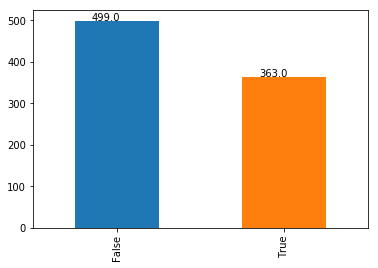

In [39]:
ax = df_final[['claim_id','claim_label']].groupby('claim_id').first().reset_index()['claim_label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(int(p.get_height()*1000)/1000), (p.get_x() +0.1, p.get_height() +0.02))

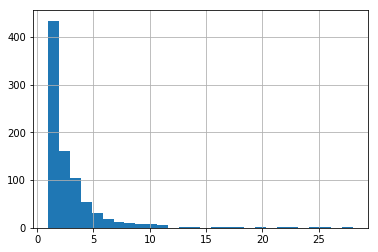

In [42]:
df_final[['claim_id','snippet_id']].groupby('claim_id').count().reset_index()['snippet_id'].hist(bins=28)

In [43]:
df_final.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'claim_id', 'snippet_content',
       'snippet_date', 'snippet_id', 'snippet_pagenum', 'snippet_title',
       'snippet_url', 'claim_content', 'claim_date', 'claim_label',
       'claim_tag', 'claim_url', 'similarity_score'],
      dtype='object')

In [44]:
df_final[['claim_id','snippet_content',
       'snippet_date', 'snippet_id', 'snippet_pagenum', 'snippet_title',
       'snippet_url', 'claim_content', 'claim_date', 'claim_label',
       'claim_tag', 'claim_url', 'similarity_score']].to_csv('datasets/relevent_snippets.csv')